In [1]:
cd ..

/home/janek/reasonable-embeddings


In [4]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *
import random
seed = 2022
random.seed(seed)

In [5]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>
swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [6]:
def make_dataset(onto, fact, n_queries=20000):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=10, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

idx_te, X_te, y_te = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact)
    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
rng = np.random.default_rng(seed)
data = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.06
demacare - balance 0.0351
stuff - balance 0.2382
swo - balance 0.2032
ontodt - balance 0.0411
pizza - balance 0.363


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': idx_te,
    'X': X_te,
    'y': y_te
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col], random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [12]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)


T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ModifiedReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20240710T151848/reasoner.pt'))

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data_tr, data_vl, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params, identities_weight=0.038, identitity_weight_decay=0.91)


----
frozen reasoner head (transfer)
train epoch 00/10 | batch 2251/2250 | loss 1.5475 | val loss 1.4314 | acc 0.6281 | f1 0.3321 | prec 0.2311 | recall 0.5900 | roc auc 0.6605 | pr auc 0.2941 | elapsed 167.35s
train epoch 01/10 | batch 2251/2250 | loss 0.9880 | val loss 0.5612 | acc 0.8140 | f1 0.5160 | prec 0.4357 | recall 0.6328 | roc auc 0.8241 | pr auc 0.5467 | elapsed 1181.21s
train epoch 02/10 | batch 2251/2250 | loss 0.5311 | val loss 0.3773 | acc 0.8697 | f1 0.6079 | prec 0.5752 | recall 0.6445 | roc auc 0.8814 | pr auc 0.6642 | elapsed 372.59s
train epoch 03/10 | batch 2251/2250 | loss 0.3981 | val loss 0.3139 | acc 0.8883 | f1 0.6529 | prec 0.6365 | recall 0.6703 | roc auc 0.9087 | pr auc 0.7240 | elapsed 428.61s
train epoch 04/10 | batch 2251/2250 | loss 0.3333 | val loss 0.2827 | acc 0.8983 | f1 0.6772 | prec 0.6737 | recall 0.6807 | roc auc 0.9225 | pr auc 0.7559 | elapsed 1796.95s
train epoch 05/10 | batch 2251/2250 | loss 0.2907 | val loss 0.2639 | acc 0.9038 | f1 0.692

In [13]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
transfer_r_orig_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_orig_head = ReasonerHead(**head_params)
transfer_r_orig_head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


print('frozen reasoner head (transfer) original')
T.manual_seed(seed)
transfer_log_orig = train(data_tr, data_vl, transfer_r_orig_head, transfer_r_orig_embs, freeze_reasoner=True, run_name='frozen transfer original', **train_params)


frozen reasoner head (transfer) original
train epoch 00/10 | batch 2251/2250 | loss 1.3056 | val loss 1.2909 | acc 0.6796 | f1 0.3744 | prec 0.2697 | recall 0.6118 | roc auc 0.7092 | pr auc 0.3507 | elapsed 167.68s
train epoch 01/10 | batch 2251/2250 | loss 0.7460 | val loss 0.4792 | acc 0.8455 | f1 0.5590 | prec 0.5058 | recall 0.6246 | roc auc 0.8490 | pr auc 0.5930 | elapsed 361.17s
train epoch 02/10 | batch 2251/2250 | loss 0.3898 | val loss 0.3496 | acc 0.8859 | f1 0.6344 | prec 0.6372 | recall 0.6317 | roc auc 0.8905 | pr auc 0.6952 | elapsed 399.57s
train epoch 03/10 | batch 2251/2250 | loss 0.2966 | val loss 0.3046 | acc 0.9003 | f1 0.6727 | prec 0.6930 | recall 0.6535 | roc auc 0.9101 | pr auc 0.7406 | elapsed 383.48s
train epoch 04/10 | batch 2251/2250 | loss 0.2519 | val loss 0.2825 | acc 0.9060 | f1 0.6871 | prec 0.7182 | recall 0.6586 | roc auc 0.9205 | pr auc 0.7641 | elapsed 413.15s
train epoch 05/10 | batch 2251/2250 | loss 0.2239 | val loss 0.2708 | acc 0.9095 | f1 0.6

local/out/exp/20240710T175051
------
Frozen pre-trained reasoner head original
train time 3831.9121465682983
           mean     std   micro
acc      0.9145  0.0667  0.9145
prec     0.7613  0.0831  0.7502
recall   0.6459  0.0610  0.6823
f1       0.6967  0.0587  0.7146
auc_roc  0.9183  0.0243  0.9361
auc_pr   0.7602  0.0681  0.7991
------
Frozen pre-trained reasoner head
train time 7002.225457429886
           mean     std   micro
acc      0.9156  0.0630  0.9156
prec     0.6981  0.0972  0.7295
recall   0.6949  0.0768  0.7338
f1       0.6949  0.0805  0.7317
auc_roc  0.9202  0.0336  0.9440
auc_pr   0.7627  0.0929  0.8178


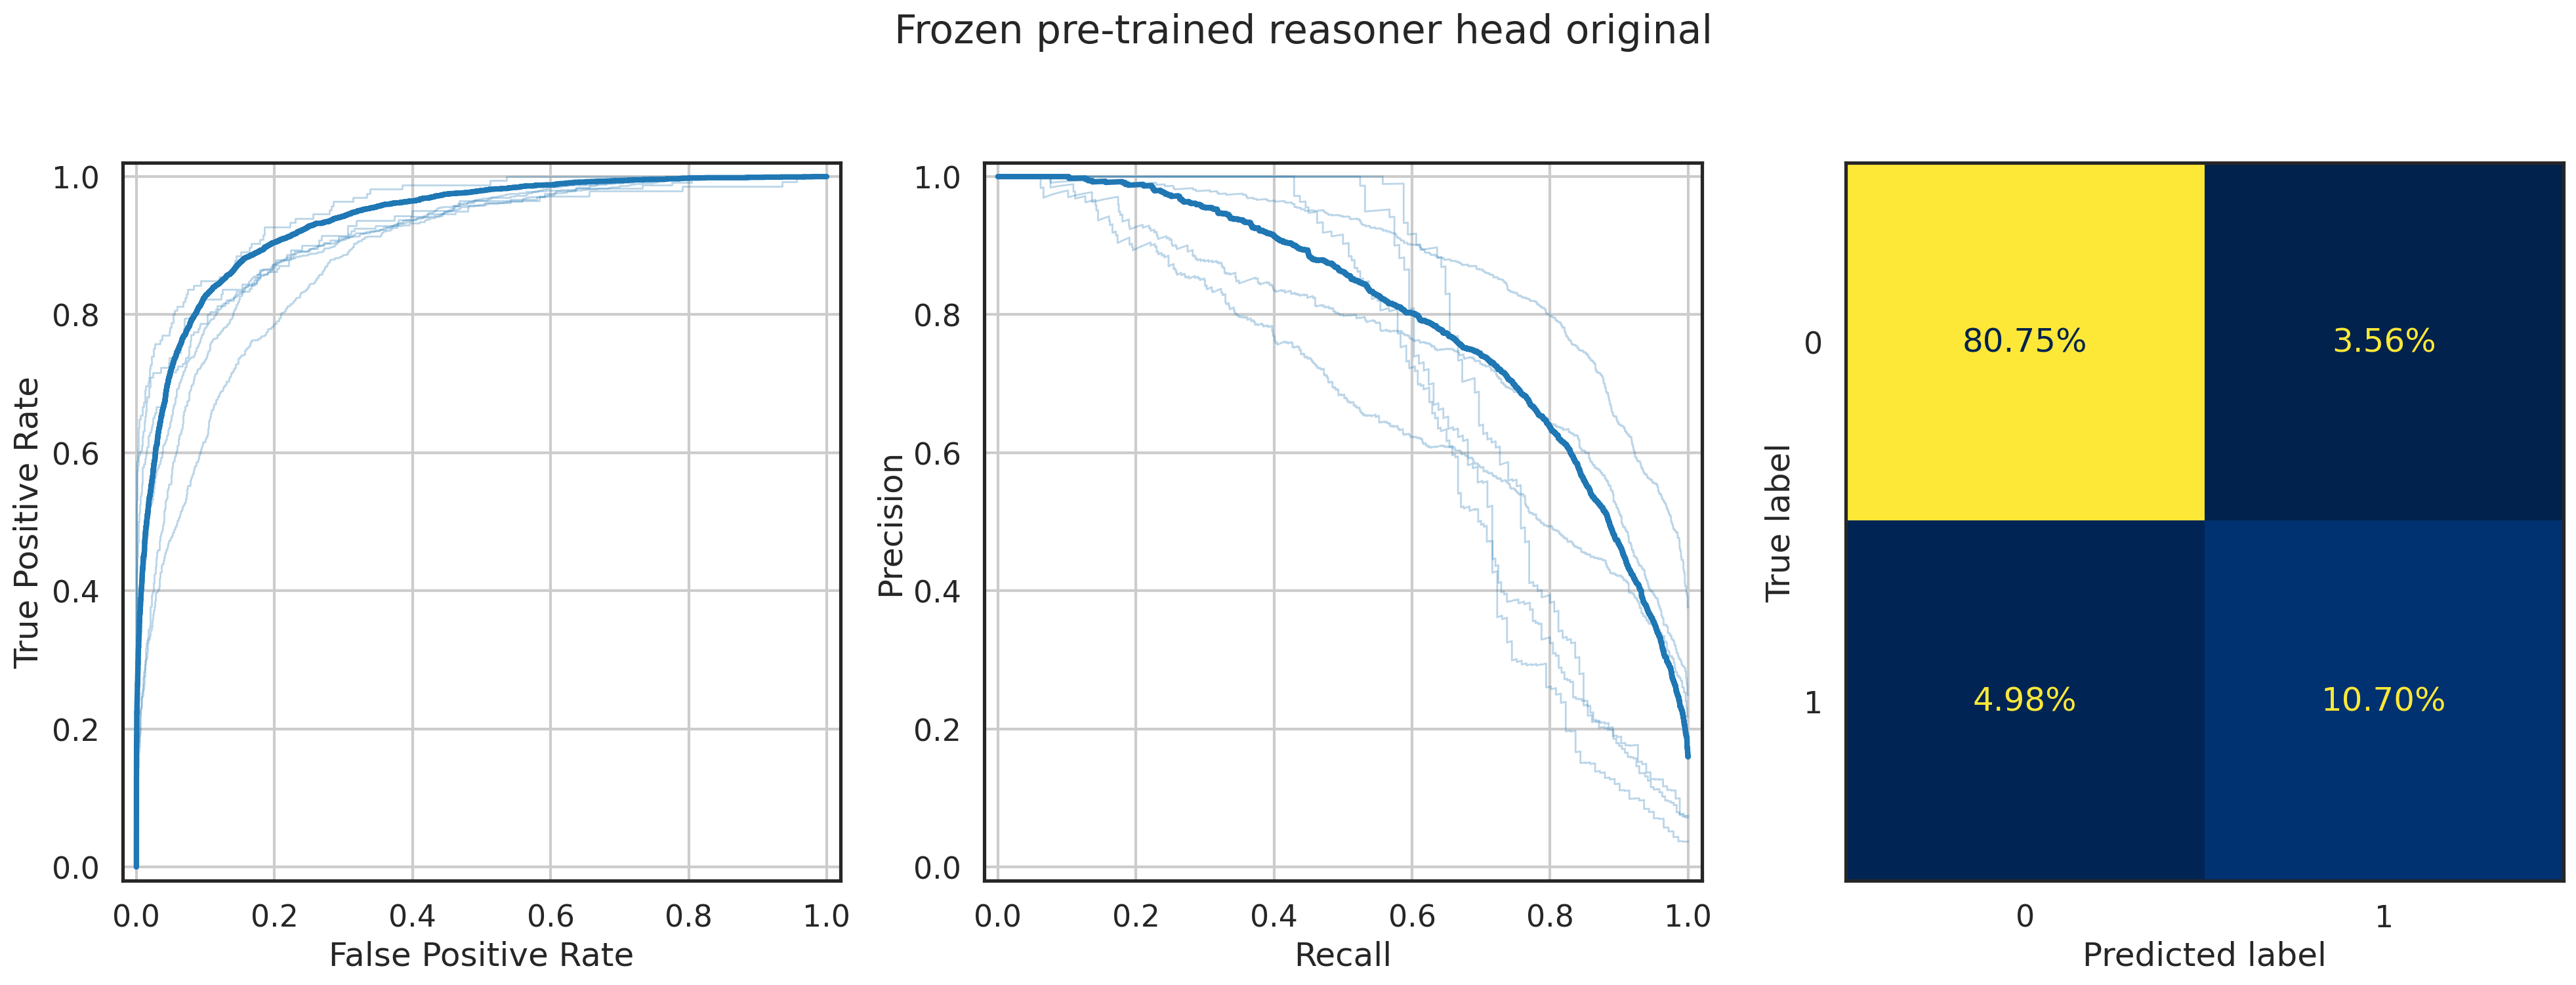

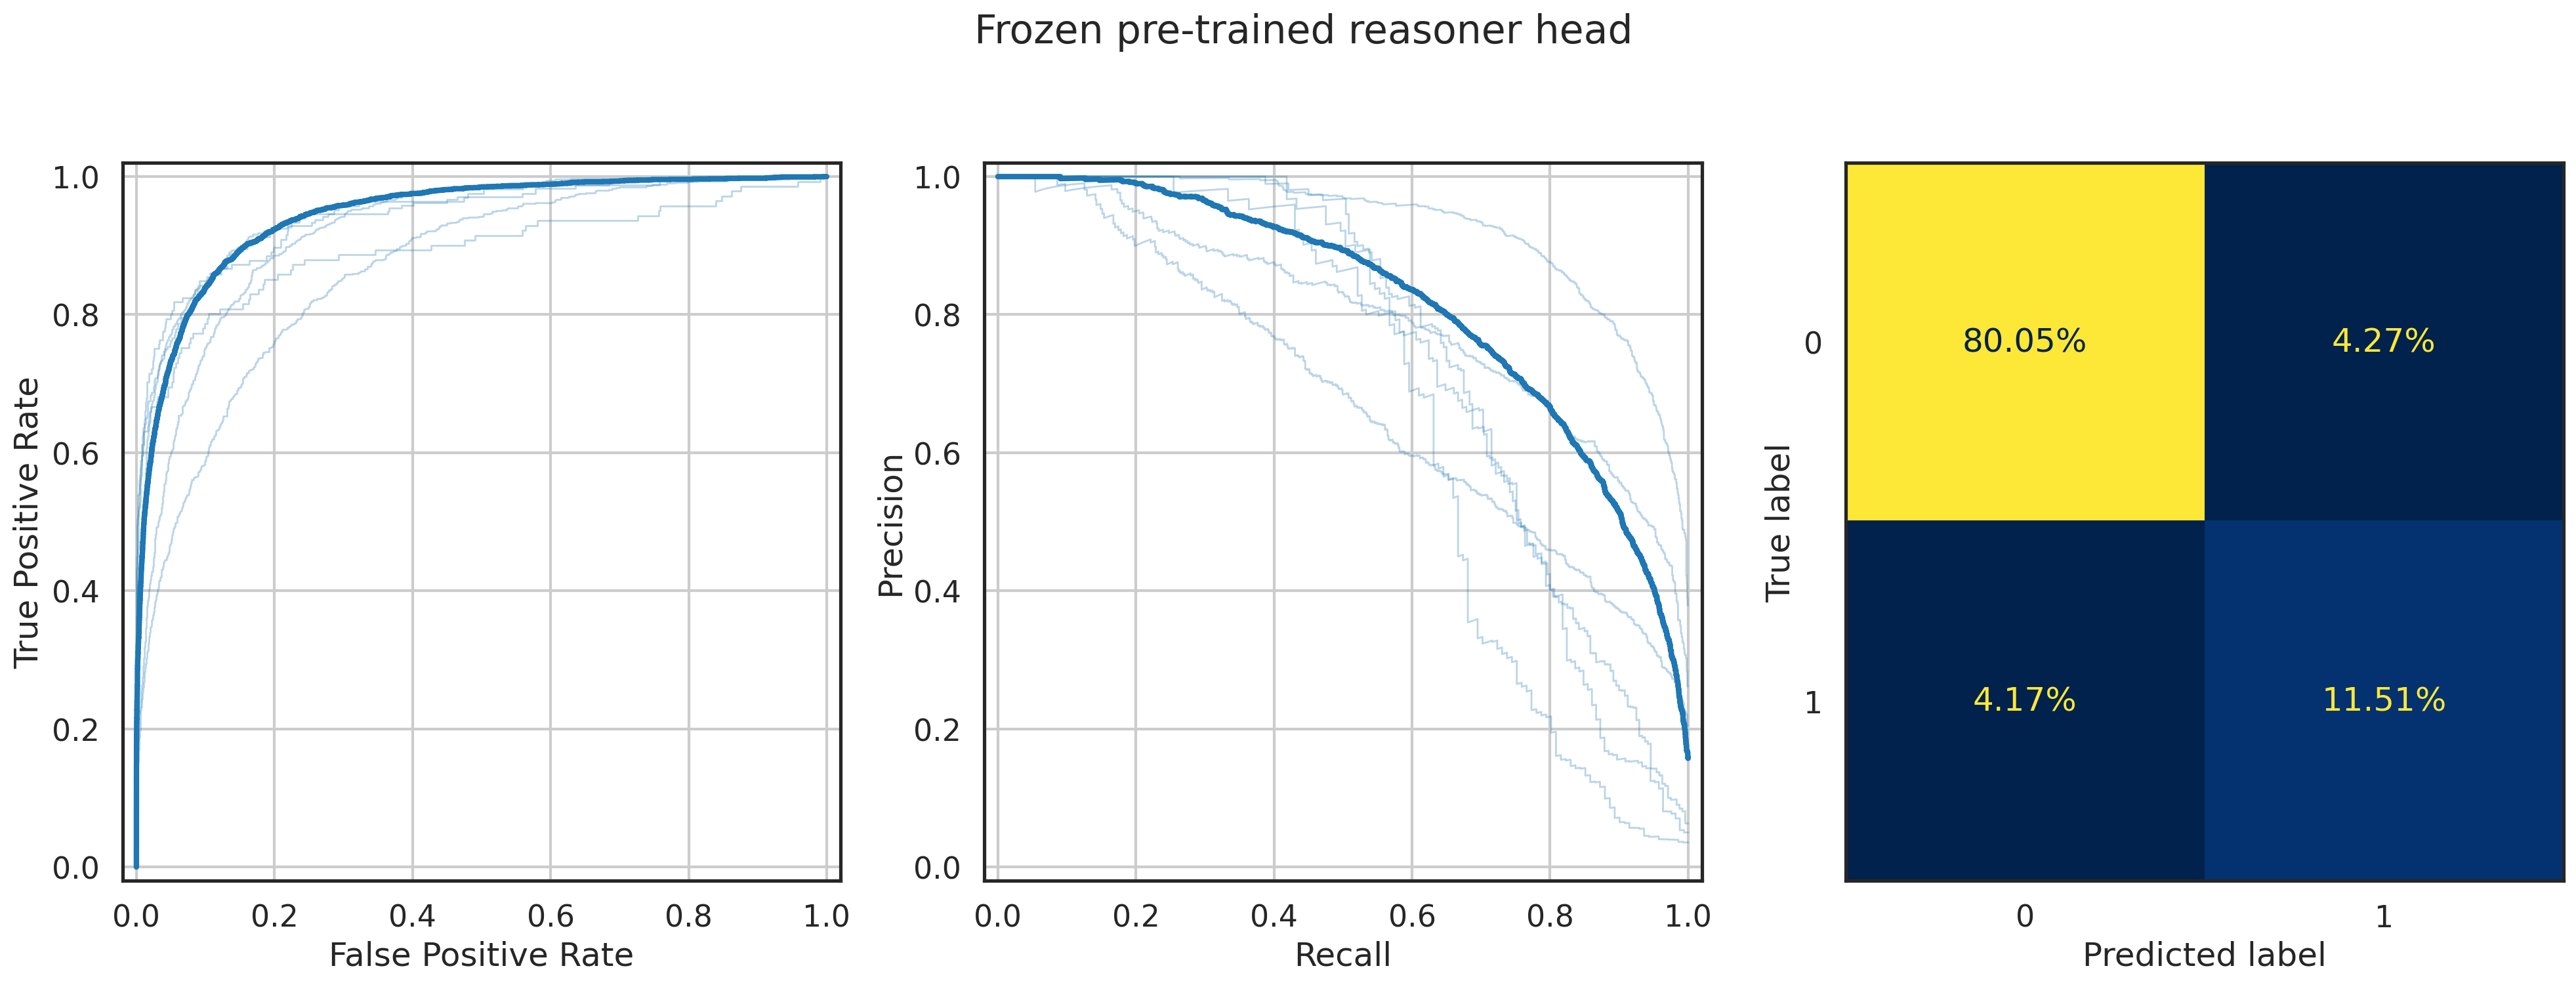

In [14]:
titles = 'Expected', 'Frozen pre-trained reasoner head original', 'Frozen pre-trained reasoner head'
logs = transfer_log_orig, transfer_log
heads = transfer_r_orig_head, transfer_r_head
embeddings = transfer_r_orig_embs, transfer_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        if title == 'Frozen pre-trained reasoner head original':
            _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
        else:
            _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)

    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [15]:
base = 'local/out/exp/' + 'exp5_frozen10'
mkdirp(base)
T.save(transfer_r_embs, base+'/emb_mod_layer.pt')
T.save(transfer_r_orig_embs, base+'/emb_orig_layer.pt')

In [35]:
a = T.load(base+'/emb_orig_layer.pt')

In [42]:
b = T.load(base+'/emb_mod_layer.pt')

In [16]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Frozen pre-trained reasoner head original
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9668  0.6900  0.7831  0.6167   0.9449  0.7669  wildlife
61  0.9828  0.7184  0.8381  0.6286   0.9174  0.7294  demacare
62  0.8652  0.6977  0.7494  0.6527   0.9070  0.7771     stuff
63  0.8348  0.6105  0.5853  0.6379   0.8744  0.6662       swo
64  0.9812  0.7525  0.8201  0.6951   0.9614  0.8110    ontodt
65  0.8600  0.8006  0.8289  0.7741   0.9233  0.8921     pizza
----------
Frozen pre-trained reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9665  0.7048  0.7477  0.6667   0.9484  0.7653  wildlife
61  0.9698  0.5694  0.5674  0.5714   0.8828  0.6080  demacare
62  0.8665  0.7157  0.7265  0.7051   0.9279  0.8071     stuff
63  0.8288  0.5968  0.5716  0.6244   0.8649  0.6734       swo
64  0.9720  0.6744  0.6444  0.7073   0.9468  0.7514    ontodt
65  0.8815  0.8367  0.8372  0.8361   0.9495  0.9264     pizza


In [69]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.5

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rec': np.arange(len(X_te_2))[błędne_predykcje],
    'True': y_te_2[błędne_predykcje],
    'Pred': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'F{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)



/tmp/ipykernel_8029/1003111826.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_te_2 = np.array(X_te)


In [71]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:0.2f}'.format):  # more options can be specified also
    print(wyniki)

        Rec  True  Pred F0                                                 F1  \
0         2     1  0.09  0  (4, (7, 24, (4, (4, (3, 165), (3, (7, 38, (3, ...   
1        44     0  0.82  0  (4, (3, (4, (3, (4, -2, 45)), (4, (3, (4, (3, ...   
2        45     0  0.85  0  (4, (4, (3, (4, (4, 157, 0), (3, 25))), (3, 12...   
3        97     1  0.01  0  (7, 20, (3, (7, 41, (4, (3, (7, 39, 128)), (3,...   
4       111     1  0.00  0  (4, (3, (7, 42, (4, (4, (3, (4, (7, 48, (3, (7...   
5       155     1  0.02  0  (7, 24, (3, (4, (3, (7, 49, (3, 60))), (4, (3,...   
6       160     0  0.96  0                  (4, 249, (4, (3, 147), (3, 150)))   
7       161     1  0.01  0  (4, (7, 27, (4, (4, (7, 30, (3, (4, (3, 244), ...   
8       253     1  0.05  0  (4, (4, (4, 27, (4, (4, 4, (3, (7, 36, (7, 44,...   
9       280     1  0.07  0  (7, 43, (7, 51, (4, (4, (4, (4, 249, (3, (7, 3...   
10      319     0  0.60  0  (4, (4, (3, (4, (7, 0, 119), (7, 25, (7, 41, (...   
11      321     1  0.00  0  

In [61]:
T.sigmoid( transfer_r_head.encode( core(X_te[0]), transfer_r_embs[idx_te[0]]))


tensor([1.5229e-06], grad_fn=<SigmoidBackward0>)

In [62]:
T.sigmoid(transfer_r_orig_head.encode( core(X_te[0]), transfer_r_embs[idx_te[0]]))


tensor([0.0002], grad_fn=<SigmoidBackward0>)

In [17]:
T.set_printoptions(precision=4)

In [18]:
import random

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod( input, input)))
F.l1_loss(input, transfer_r_head.and_nn(im_mod(input, input)))

tensor([-0.1125,  0.0322,  0.1424, -0.1234, -0.0400, -0.1138, -0.1118, -0.0830,
         0.2008,  0.2245], grad_fn=<SelectBackward0>)
tensor([ 0.0384, -0.1315,  0.0648, -0.1071,  0.0711, -0.1677, -0.1073, -0.1429,
         0.0586,  0.0772], grad_fn=<AddBackward0>)


tensor(0.0117, grad_fn=<MseLossBackward0>)

In [19]:
import random

encoder = transfer_r_orig_embs[int(np.round(random.random() * (len(transfer_r_orig_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_orig_head.and_nn(im_mod( input, input)))
F.l1_loss(input, transfer_r_orig_head.and_nn(im_mod(input, input)))

tensor([ 0.2098,  0.0210, -0.1154, -0.0016,  0.0497,  0.0543,  0.1388,  0.1556,
        -0.1427, -0.0338], grad_fn=<SelectBackward0>)
tensor([ 0.0510,  0.0924, -0.1627,  0.1153, -0.0297,  0.1430,  0.1297,  0.0747,
        -0.1075, -0.1178], grad_fn=<AddBackward0>)


tensor(0.0772, grad_fn=<L1LossBackward0>)

In [26]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
print(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)))
print(F.l1_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)), transfer_r_head.bot_concept[0]))

tensor([ 0.2911,  0.1877,  0.0530, -0.2795,  0.3472, -0.0709,  0.0837,  0.0983,
        -0.2104, -0.1041], grad_fn=<SelectBackward0>)
tensor([ 0.3106,  0.1712,  0.0559, -0.2981,  0.3513, -0.0701,  0.0724,  0.0947,
        -0.2007, -0.1027], grad_fn=<AddBackward0>)
tensor(0.0088, grad_fn=<L1LossBackward0>)


In [42]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)))
print(F.l1_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)), input))

tensor([ 0.0473, -0.0081, -0.0314,  0.0069, -0.0618,  0.0093,  0.0473,  0.0647,
        -0.0276,  0.0595], grad_fn=<SelectBackward0>)
tensor([ 0.0052, -0.0398, -0.0376,  0.0306, -0.0041, -0.0402,  0.0367,  0.0048,
        -0.0033,  0.0432], grad_fn=<AddBackward0>)
tensor(0.0322, grad_fn=<L1LossBackward0>)


In [43]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
output = transfer_r_head.and_nn(im_mod(transfer_r_head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.2911,  0.1877,  0.0530, -0.2795,  0.3472, -0.0709,  0.0837,  0.0983,
        -0.2104, -0.1041], grad_fn=<SelectBackward0>)
tensor([ 0.1392, -0.0101, -0.0039, -0.1624,  0.1431, -0.1626, -0.1063, -0.0458,
        -0.0641,  0.0290], grad_fn=<AddBackward0>)
tensor(0.1451, grad_fn=<L1LossBackward0>)


In [45]:
print(transfer_r_head.bot_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.top_concept[0])
print(output)
print(F.l1_loss(transfer_r_head.bot_concept[0], output))

tensor([ 0.2911,  0.1877,  0.0530, -0.2795,  0.3472, -0.0709,  0.0837,  0.0983,
        -0.2104, -0.1041], grad_fn=<SelectBackward0>)
tensor([ 0.2936,  0.2399,  0.0531, -0.2797,  0.3856, -0.0701,  0.0794,  0.1559,
        -0.2557, -0.1044], grad_fn=<SqueezeBackward3>)
tensor(0.0202, grad_fn=<L1LossBackward0>)


In [46]:
print(transfer_r_head.top_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.bot_concept[0])
print(output)
print(F.l1_loss(transfer_r_head.top_concept[0], output))

tensor([-0.1209, -0.2776, -0.0367,  0.4054,  0.0284,  0.1562,  0.7496,  0.0836,
        -0.1136,  0.3484], grad_fn=<SelectBackward0>)
tensor([-0.1207, -0.2118, -0.0288,  0.4027,  0.0287,  0.1318,  0.6266,  0.0840,
        -0.0738,  0.3387], grad_fn=<SqueezeBackward3>)
tensor(0.0274, grad_fn=<L1LossBackward0>)


In [28]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input1 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input2 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input3 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))))
print(transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))


F.mse_loss(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))), transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))

tensor([ 0.0896,  0.0893,  0.1495, -0.1570,  0.1763, -0.0506, -0.0373, -0.0389,
        -0.0818, -0.0858], grad_fn=<AddBackward0>)
tensor([ 0.1033,  0.0707,  0.1435, -0.1582,  0.1680, -0.0505, -0.0436, -0.0186,
        -0.0715, -0.0744], grad_fn=<AddBackward0>)


tensor(0.0001, grad_fn=<MseLossBackward0>)

In [29]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, input3)))
print(transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

tensor([ 0.0850,  0.0844,  0.1542, -0.1388,  0.1610, -0.0516, -0.0426, -0.0422,
        -0.0735, -0.0799], grad_fn=<AddBackward0>)
tensor([ 0.0774,  0.0776,  0.1453, -0.1347,  0.1567, -0.0506, -0.0467, -0.0254,
        -0.0781, -0.0657], grad_fn=<AddBackward0>)


tensor(7.4109e-05, grad_fn=<MseLossBackward0>)

In [30]:
print(input1)
print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

F.mse_loss(input1, transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

tensor([-0.1377,  0.1033,  0.2035, -0.0095,  0.0677, -0.0641, -0.1233, -0.1963,
        -0.0341, -0.1171], grad_fn=<SelectBackward0>)
tensor([-0.1016,  0.0434,  0.1809, -0.0038,  0.0586, -0.0193, -0.0947, -0.1767,
        -0.0166, -0.0567], grad_fn=<AddBackward0>)


tensor(0.0013, grad_fn=<MseLossBackward0>)